Import everything:

In [6]:
import random

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from numpy.random import RandomState
import seaborn as sb
%matplotlib inline

import theano
import theano.tensor as T
from theano import shared

import lasagne
from lasagne.layers import InputLayer, DenseLayer
from lasagne.nonlinearities import tanh, linear, rectify
from lasagne.updates import sgd

import scipy
from scipy.stats import norm, expon, multivariate_normal
from scipy import stats
from scipy.special import psi

from utils.normalizing_flow_utils import PlanarFlow
from utils.layers_utils import ExpLayer, SimplexBijectionLayer

from sklearn.metrics import pairwise_distances
from sys import stdout
from sklearn.metrics import pairwise_kernels

sb.set_palette(sb.color_palette("Set1", n_colors=8, desat=.6))
sb.set_style("whitegrid")
sb.set_style("ticks")
sb.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.0})
sbpal = sb.color_palette()

from six.moves import cPickle

Define MMD test:

In [7]:
def MMD2u(K, m, n):
    """The MMD^2_u unbiased statistic.
    """
    Kx = K[:m, :m]
    Ky = K[m:, m:]
    Kxy = K[:m, m:]
    return 1.0 / (m * (m - 1.0)) * (Kx.sum() - Kx.diagonal().sum()) + \
        1.0 / (n * (n - 1.0)) * (Ky.sum() - Ky.diagonal().sum()) - \
        2.0 / (m * n) * Kxy.sum()


def compute_null_distribution(K, m, n, iterations=10000, verbose=False,
                              random_state=None, marker_interval=1000):
    """Compute the bootstrap null-distribution of MMD2u.
    """
    if type(random_state) == type(np.random.RandomState()):
        rng = random_state
    else:
        rng = np.random.RandomState(random_state)

    mmd2u_null = np.zeros(iterations)
    for i in range(iterations):
        if verbose and (i % marker_interval) == 0:
            print(i),
            stdout.flush()
        idx = rng.permutation(m+n)
        K_i = K[idx, idx[:, None]]
        mmd2u_null[i] = MMD2u(K_i, m, n)

    if verbose:
        print("")

    return mmd2u_null


def kernel_two_sample_test(X, Y, kernel_function='rbf', iterations=10000,
                           verbose=False, random_state=None, **kwargs):
    """Compute MMD^2_u, its null distribution and the p-value of the
    kernel two-sample test.
    Note that extra parameters captured by **kwargs will be passed to
    pairwise_kernels() as kernel parameters. E.g. if
    kernel_two_sample_test(..., kernel_function='rbf', gamma=0.1),
    then this will result in getting the kernel through
    kernel_function(metric='rbf', gamma=0.1).
    """
    m = len(X)
    n = len(Y)
    XY = np.vstack([X, Y])
    K = pairwise_kernels(XY, metric=kernel_function, **kwargs)
    mmd2u = MMD2u(K, m, n)
    if verbose:
        print("MMD^2_u = %s" % mmd2u)
        print("Computing the null distribution.")

    mmd2u_null = compute_null_distribution(K, m, n, iterations,
                                           verbose=verbose,
                                           random_state=random_state)
    p_value = max(1.0/iterations, (mmd2u_null > mmd2u).sum() /
                  float(iterations))
    if verbose:
        print("p-value ~= %s \t (resolution : %s)" % (p_value, 1.0/iterations))

    return mmd2u, mmd2u_null, p_value

Define utils for Dirichlet plotting:

In [8]:
# some utils for dirichlet; some of which is from http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/
corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]
def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

def bc2xy(bc, tol=1.e-3):
    '''converts 3d barycentric coords to 2d cartesian.'''
    return corners.T.dot(bc)

class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                     reduce(mul, [gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])

def draw_pdf_contours(dist, subdiv=5, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]
    plt.tricontourf(trimesh, pvals, np.arange(0,15,0.1),**kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    
def KLdir(alpha,beta):
    #computes KL(p||q), where p and q are dirichlets with parameters alpha and beta, respectively.
    alpha_0 = alpha.sum()
    beta_0 = beta.sum()
    kl = np.log(scipy.special.gamma(alpha_0))-np.log(scipy.special.gamma(alpha)).sum()-np.log(scipy.special.gamma(beta_0))+np.log(scipy.special.gamma(beta)).sum()+((alpha-beta)*(psi(alpha)-psi(alpha_0))).sum()
    return(kl)

## Parameters:

In [9]:
#params for data generation
n = 300

#dirichlet parameters
alpha_vals = [1,2,3]
alpha = np.array(alpha_vals, dtype=theano.config.floatX)
d = alpha.shape[0] #dimensionality of dirichlet
dim = d-1 #dimensionality of network input

#params for augmented lagrange algorithm
updates = 10
n_lagr = 1000
c = 0.05
lam = np.zeros(d)
gamma = 0.25
n_norm = 1000

#params for neural net
max_iter_early = 3000  #num of iterations
max_iter_last = 3000   #num of iterations after the last lagrangian step
nHid = 10 #num of hidden layers
lr = 1 #learning rate for adadelta

Fit network:

In [10]:
np.random.seed(222)
lasagne.random.set_rng(RandomState(222))
#define empty vectors for plotting:
f1 = []
f2 = []
f3 = []


#-------- simbolic variables ---------------
#Symbolic variables:
x = T.matrix("x") #not necessarily useful, auxiliary variable
z = T.matrix("z") #input
ct = T.scalar("ct") #lagrangian
lamt = T.vector("lamt") #lagrangian

#-------- build objective function ----------------
digamma_alpha = psi(alpha)
digamma_of_sum = psi(alpha.sum())
def constraint(x):
    return T.log(x).mean(axis=0)-(digamma_alpha-digamma_of_sum)
Tcon = theano.function(inputs=[x], outputs=constraint(x))

l_hid = InputLayer(shape=(None, dim), input_var=z)
for i in xrange(nHid):
    out = lasagne.layers.get_output(l_hid)
    l_hid = PlanarFlow(l_hid)
    if i == 0:
        logdet = l_hid.det(out)
    else:
        logdet += l_hid.det(out)

out = lasagne.layers.get_output(l_hid)
l_hid = SimplexBijectionLayer(l_hid)
logdet += l_hid.det(out)

# entropy and output function
lognormalizing_const = -1/2.0 * (np.log(2) + np.log(np.pi))
logp_raw = (- z**2 / 2 + lognormalizing_const).sum()
logp = logp_raw - logdet
logp_func = theano.function([z], logp)
entropy = -logp / n
entropy_func = theano.function([z], entropy)
out = lasagne.layers.get_output(l_hid)
out_func = theano.function([z], out)

#objective function
params = lasagne.layers.get_all_params(l_hid)
grad_func1 = T.grad(-entropy+T.dot(lamt,constraint(out)), params)
con1 = constraint(out[:(n/2),])
con2 = constraint(out[(n/2):,])
grad_con = T.Lop(con1, params, con2)
aug_L_grad = [i + ct * j for i,j in zip(grad_func1, grad_con)]

#update function
updates_sgd = lasagne.updates.adadelta(aug_L_grad, params, learning_rate=lr)
Taug_L_grad = theano.function(inputs=[z,ct,lamt], outputs=aug_L_grad, updates=updates_sgd)

#-------------- start running ------------------------
#initialize optimization:
cur_aug_L = 0.0
inp = np.array(np.random.normal(size=[n, dim]), dtype=theano.config.floatX)
hk = Tcon(out_func(inp))
norms = np.empty(n_norm)
norms_new = np.empty(n_norm)
for i in xrange(n_norm):
    inp = np.array(np.random.normal(size=[n_lagr, dim]), dtype=theano.config.floatX)
    norms[i] = np.linalg.norm(Tcon(out_func(inp)))

#Loop through how many times the augmented Lagrangian parameters will be updated:
for i in xrange(updates):    
    #Reset step size:
    #For fixed augmented Lagrangian parameters, optimize using SGD:
    if i == updates - 1: #(* YG: just so that we can run more iteration in the last lagrangian step)
        max_iter = max_iter_last
    else:
        max_iter = max_iter_early
    #de-comment the step part to update lambda after each parameter update:
    #step = 1.0
    for k in xrange(max_iter):
        #For regular GD:
        inp = np.array(np.random.normal(size=[n, dim]), dtype=theano.config.floatX)
        cur_aug_L_grad = Taug_L_grad(inp, c, lam)
        inp = np.array(np.random.normal(size=[n, dim]), dtype=theano.config.floatX)
        rlt_temp = out_func(inp)
        con_temp = Tcon(rlt_temp)
        f1.append(entropy_func(inp))
        f2.append(np.dot(lam,con_temp))
        f3.append(c*np.linalg.norm(con_temp)**2/2.0)
        #lam += step*con_temp
        #step = 1/(k+2)
        if (k+1) % 1000 == 0:
            print "after %d iteration, Esimated entropy: %.4f" % (k+1, entropy_func(inp))
            
    
    #Print objective function after having optimized:
    print "Lagrangian step %d, Esimated entropy: %.4f" % (i+1, entropy_func(inp))
    print "constraint enforcement parameter=%.4f"%c
    print "lagrange multiplier estimate:", lam
    print "constraints:", con_temp
    print "*" + "-" * 50
    
    #Update augmented Lagrangian parameters:
    inp_lagr = np.array(np.random.normal(size=[n_lagr, dim]), dtype=theano.config.floatX)
    hk_new = Tcon(out_func(inp_lagr))
    lam += c*hk_new
    for i in xrange(n_norm):
        inp = np.array(np.random.normal(size=[n_lagr, dim]), dtype=theano.config.floatX)
        norms_new[i] = np.linalg.norm(Tcon(out_func(inp)))
    t,p = scipy.stats.ttest_ind(norms_new, gamma*norms, equal_var = False)
    u = np.random.rand(1)
    if u < 1-p/2.0 and t>0:
        c *= 4
    hk = hk_new
print "The true entropy is: ", scipy.stats.dirichlet.entropy(alpha)
#save out_func
#f = open("out_func_alpha123.save", 'wb')
#cPickle.dump(out_func, f, protocol=cPickle.HIGHEST_PROTOCOL)
#f.close()

after 1000 iteration, Esimated entropy: -0.7158
after 2000 iteration, Esimated entropy: -0.7170
after 3000 iteration, Esimated entropy: -0.6984
Lagrangian step 1, Esimated entropy: -0.6984
constraint enforcement parameter=0.0500
lagrange multiplier estimate: [ 0.  0.  0.]
constraints: [ 0.84145091 -0.21041815 -0.73221756]
*--------------------------------------------------
after 1000 iteration, Esimated entropy: -0.7144
after 2000 iteration, Esimated entropy: -0.7322
after 3000 iteration, Esimated entropy: -0.7681
Lagrangian step 2, Esimated entropy: -0.7681
constraint enforcement parameter=0.2000
lagrange multiplier estimate: [ 0.03900297 -0.00999586 -0.03393907]
constraints: [ 0.35644848 -0.03082212 -0.50008799]
*--------------------------------------------------
after 1000 iteration, Esimated entropy: -0.9251
after 2000 iteration, Esimated entropy: -0.8852
after 3000 iteration, Esimated entropy: -0.8548
Lagrangian step 3, Esimated entropy: -0.8548
constraint enforcement parameter=0.

## Plot 1:

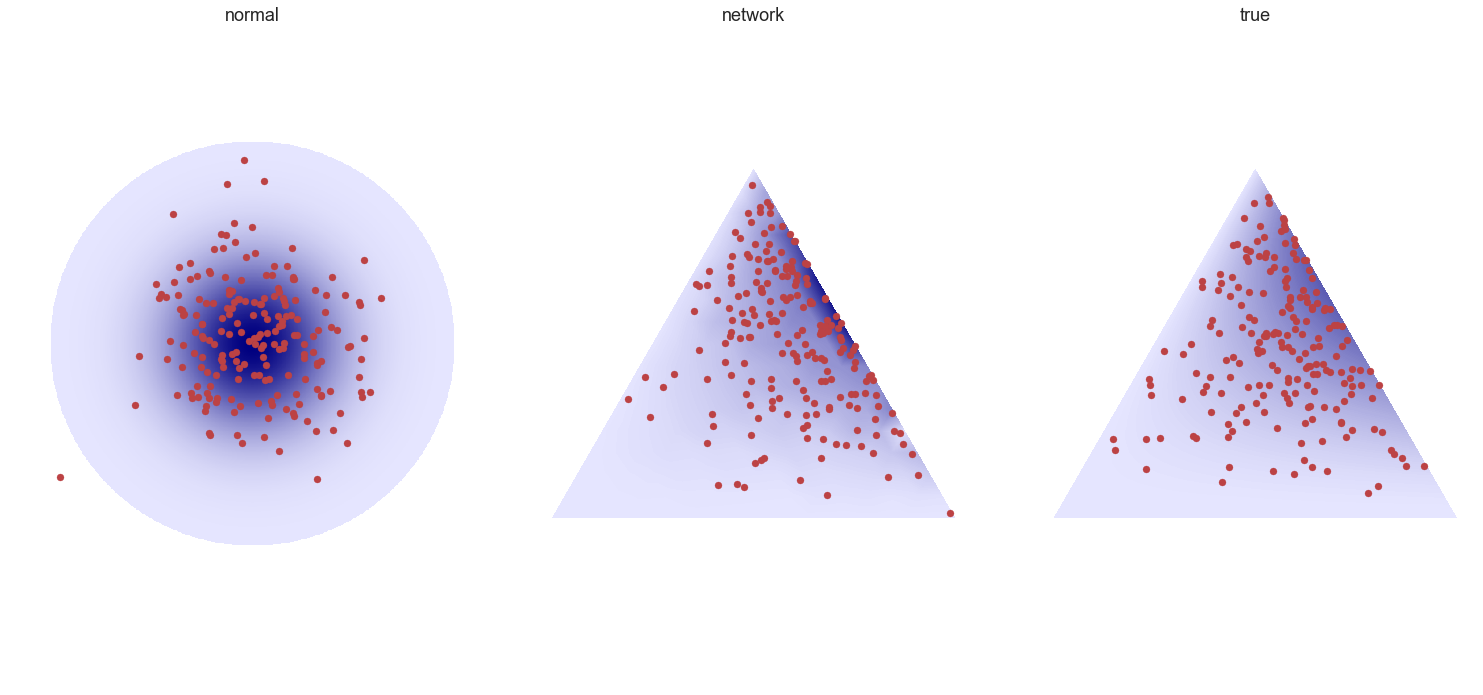

In [11]:
def closest(simplex_point,n):
    #constructs an nxn grid and gives back the point on the grid which, after being transformed by the network
    #is closest to simplex_point
    x = np.linspace(-3.5,3.5,n)
    clos = np.array([[x[0],x[0]]])
    dist = np.linalg.norm(simplex_point-out_func(clos))
    for i in xrange(n):
        for j in xrange(n):
            aux_clos = np.array([[x[i],x[j]]])
            aux_dist = np.linalg.norm(simplex_point-out_func(aux_clos))
            if aux_dist<dist:
                clos = aux_clos
                dist = aux_dist
    return(clos)

plt.figure(figsize=(21,10))

plt.subplot(1,3,1)

n_plot = 500
dist = multivariate_normal([0,0],[[1,0],[0,1]])
x = np.linspace(-3.5,3.5,n_plot)
Z = np.zeros([n_plot,n_plot])
for i in xrange(n_plot):
    for j in xrange(n_plot):
                Z[i,j] = dist.pdf([x[i],x[j]])
mycm = sb.light_palette("navy", as_cmap=True)
mycm.set_under('w')
#plt.contourf(x,x,Z,cmap=mycm)
plt.imshow(Z,extent=(-3.5,3.5,-3.5,3.5),cmap=mycm,vmin=0.000325)
plt.axis("off")
norm_sample = dist.rvs(200)
xns = norm_sample[:,0]
yns = norm_sample[:,1]
plt.scatter(xns,yns,c=sbpal[0])
plt.title("normal")
plt.axis("equal")

plt.subplot(1,3,2)#network

n_plot = 30
mycm = sb.light_palette("navy", as_cmap=True)
mycm.set_under('w')
#plt.contourf(x,x,Z,cmap=mycm)
refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)
pvals = [np.exp(logp_func(closest(xy2bc(xy),n_plot))) for xy in zip(trimesh.x, trimesh.y)]
plt.tricontourf(trimesh, pvals, np.arange(0,15,0.1), cmap=mycm)
plt.axis("equal")
plt.axis("off")
#print simplex_points
#print simplex_points.reshape([n_plot**2,d])
#print log_p_net
#print log_p_net.reshape(n_plot**2)
inp = np.array(np.random.normal(size=[200, dim]), dtype=theano.config.floatX)
s = out_func(inp).T
x,y = bc2xy(s)
plt.scatter(x,y,c=sbpal[0])
plt.title("network")

plt.subplot(1,3,3)#true

mycm = sb.light_palette("navy", as_cmap=True)
#mycm = sns.cubehelix_palette(light=1, as_cmap=True)
#mycm = sb.color_palette("Blues",as_cmap=True)
draw_pdf_contours(Dirichlet(alpha_vals), subdiv=5, cmap=mycm)
#plt.scatter([0,.1,.2,.3],[0.1,0.2,0.3,0.4],c=sbpal[0])

# add text
#plt.text(0.51,np.sqrt(0.75), r'$[1,0,0]$', fontsize=15)
#plt.text(-0.13,0, r'$[0,0,1]$', fontsize=15)
#plt.text(1.01,0, r'$[0,1,0]$', fontsize=15)
#plt.plot([.8,.9],[.6,.6],c=sbpal[1])
#plt.text(.95,.59, r'true', fontsize=15)

# draw some points
#s = np.random.dirichlet(alpha, 200).T
s = np.random.dirichlet(alpha, 200).T
x,y = bc2xy(s)
plt.scatter(x,y,c=sbpal[0])
plt.title("true")
plt.axis("equal")

plt.tight_layout()

# save
#plt.savefig("dirichlet_comparison.png")

## Plot 2

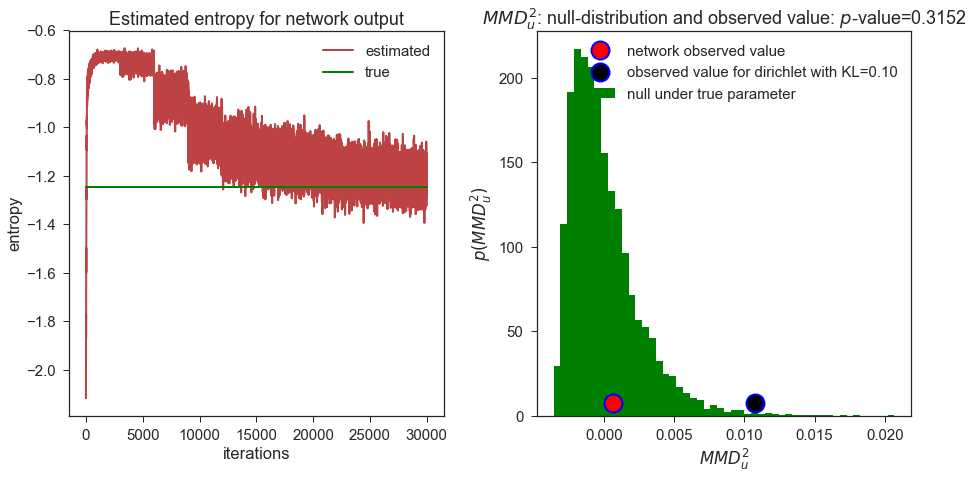

In [12]:
#f = open("out_func_alpha123.save", 'rb')
#out_func = cPickle.load(f)
#f.close()
zs = np.array(np.random.normal(size=[n, dim]), dtype=theano.config.floatX)
xs = out_func(zs)
xs_true = scipy.stats.dirichlet.rvs(alpha_vals, size=n)
X = xs
Y = xs_true
sigma2 = np.median(pairwise_distances(X, Y, metric='euclidean'))**2
mmd2u, mmd2u_null, p_value = kernel_two_sample_test(X, Y, kernel_function='rbf', gamma=1.0/sigma2)

beta = [1.3, 1.7, 3.3]
xsb = scipy.stats.dirichlet.rvs(beta, size=n)
xs_trueb = scipy.stats.dirichlet.rvs(alpha_vals, size=n)
Xb = xsb
Yb = xs_trueb
sigma2b = np.median(pairwise_distances(Xb, Yb, metric='euclidean'))**2
mmd2ub, mmd2u_nullb, p_valueb = kernel_two_sample_test(Xb, Yb, kernel_function='rbf', gamma=1.0/sigma2)


plt.figure(figsize=(14,7))

plt.subplot(1,2,1)
plt.plot(f1)
plt.plot([0,max_iter_early*(updates-1)+max_iter_last],[scipy.stats.dirichlet.entropy(alpha_vals),scipy.stats.dirichlet.entropy(alpha_vals)], color="g")
plt.legend(["estimated","true"])
plt.title("Estimated entropy for network output")
plt.ylabel("entropy")
plt.xlabel("iterations")

plt.subplot(1,2,2)
prob, bins, patches = plt.hist(mmd2u_null, bins=50, normed=True, color="g")
plt.plot(mmd2u, prob.max()/30, 'o', markersize=18, markeredgecolor='b', markeredgewidth=2, color="r")
#probb, binsb, patchesb = plt.hist(mmd2u_nullb, bins=50, normed=True, color="k")
plt.plot(mmd2ub, prob.max()/30, 'o', markersize=18, markeredgecolor='b', markeredgewidth=2, color="k")
plt.xlabel('$MMD^2_u$')
plt.ylabel('$p(MMD^2_u)$')
plt.title('$MMD^2_u$: null-distribution and observed value: $p$-value=%s'% p_value)
plt.legend(["network observed value","observed value for dirichlet with KL=%.2f"%KLdir(np.array(beta), np.array(alpha_vals)), "null under true parameter"])

plt.tight_layout()
#plt.savefig("dirichlet_performance.png")